In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import gensim
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel, TfidfModel
from gensim.models.phrases import Phrases, Phraser

file_path = "/content/hasil_preprocessing.csv"
data = pd.read_csv(file_path)

def parse_list_string(text):
    try:
        return ast.literal_eval(text)
    except:
        return []

data['tokens'] = data['StopwordRemoval'].apply(parse_list_string)
docs = [doc for doc in data['tokens'] if len(doc) > 0]

ImportError: Unable to import required dependencies:
numpy: No module named 'numpy'

In [4]:
bigram = Phrases(docs, min_count=3, threshold=10)
trigram = Phrases(bigram[docs], threshold=10)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

docs = [trigram_mod[bigram_mod[doc]] for doc in docs]

id2word = corpora.Dictionary(docs)
id2word.filter_extremes(no_below=5, no_above=0.9)

corpus = [id2word.doc2bow(text) for text in docs]

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [5]:
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []

    print("Mulai mencari jumlah topik terbaik...")
    for num_topics in range(start, limit, step):
        print(f"Processing k={num_topics}...")

        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            alpha='auto',
            per_word_topics=True
        )
        model_list.append(model)

        coherencemodel = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start, limit, step = 2, 11, 1

model_list, coherence_values = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus_tfidf,
    texts=docs,
    start=start,
    limit=limit,
    step=step
)

Mulai mencari jumlah topik terbaik...
Processing k=2...
Processing k=3...
Processing k=4...
Processing k=5...
Processing k=6...
Processing k=7...
Processing k=8...
Processing k=9...
Processing k=10...


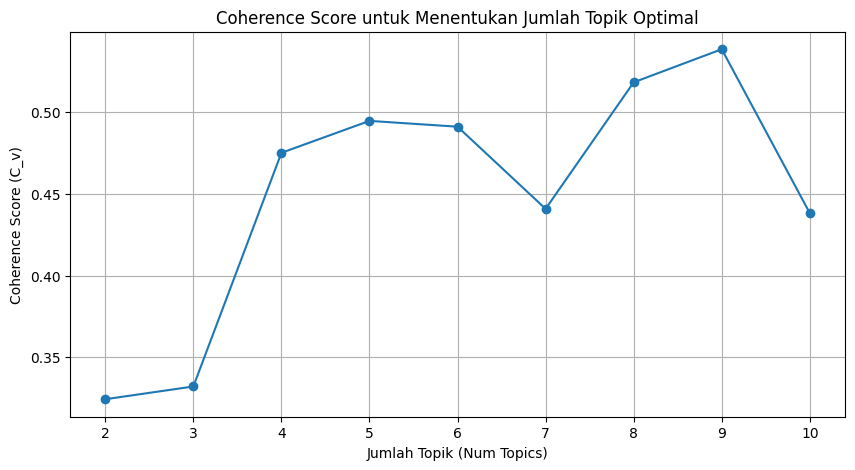

Num Topics = 2, Coherence Score = 0.3244
Num Topics = 3, Coherence Score = 0.3322
Num Topics = 4, Coherence Score = 0.4749
Num Topics = 5, Coherence Score = 0.4944
Num Topics = 6, Coherence Score = 0.4909
Num Topics = 7, Coherence Score = 0.4407
Num Topics = 8, Coherence Score = 0.5180
Num Topics = 9, Coherence Score = 0.5382
Num Topics = 10, Coherence Score = 0.4381

Jumlah topik optimal berdasarkan score tertinggi adalah: 9

Topik pada Model Terbaik (k=9):
Topik 0: 0.067*"bagus" + 0.052*"aplikasi" + 0.036*"mantap" + 0.034*"mudah" + 0.034*"pemula" + 0.032*"saham" + 0.030*"stockbit" + 0.027*"belajar" + 0.026*"membantu" + 0.023*"oke"
Topik 1: 0.024*"masuk" + 0.022*"deposit" + 0.021*"withdraw" + 0.021*"withdrawal" + 0.014*"uang" + 0.014*"verifikasi" + 0.014*"membantu_pemula" + 0.013*"kerja" + 0.011*"proses" + 0.011*"penarikan"
Topik 2: 0.030*"lumayan" + 0.029*"investasi_saham" + 0.025*"the_best" + 0.018*"pokoknya" + 0.017*"gampang" + 0.016*"eror_mulu" + 0.015*"tolong" + 0.015*"tambahin" 

In [6]:
x = range(start, limit, step)
plt.figure(figsize=(10, 5))
plt.plot(x, coherence_values, marker='o')
plt.xlabel("Jumlah Topik (Num Topics)")
plt.ylabel("Coherence Score (C_v)")
plt.title("Coherence Score untuk Menentukan Jumlah Topik Optimal")
plt.grid(True)
plt.show()

for m, cv in zip(x, coherence_values):
    print(f"Num Topics = {m}, Coherence Score = {cv:.4f}")

best_idx = coherence_values.index(max(coherence_values))
best_k = x[best_idx]
best_lda_model = model_list[best_idx]

print(f"\nJumlah topik optimal berdasarkan score tertinggi adalah: {best_k}")
print(f"\nTopik pada Model Terbaik (k={best_k}):")
for idx, topic in best_lda_model.print_topics(-1):
    print(f"Topik {idx}: {topic}")

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = []

    for i, row in enumerate(ldamodel[corpus]):
        row_topics = row[0] if isinstance(row, tuple) else row
        row_topics = sorted(row_topics, key=lambda x: (x[1]), reverse=True)

        top_topic = row_topics[0][0]
        top_topic_prob = row_topics[0][1]

        topic_keywords = ", ".join([w for w, p in ldamodel.show_topic(top_topic)])

        sent_topics_df.append([
            i, top_topic, round(top_topic_prob, 4), topic_keywords, " ".join(texts[i])
        ])

    result = pd.DataFrame(sent_topics_df,
                          columns=["doc_index", "dominant_topic", "topic_probability", "topic_keywords", "tokens"])
    return result

df_topic_assign = format_topics_sentences(best_lda_model, corpus_tfidf, docs)
df_topic_assign = df_topic_assign.rename(columns={"tokens": "lda_tokens"})

final_df = data.join(df_topic_assign.set_index("doc_index"), how="left")

final_df = final_df.drop(columns=['lower_content','clean_content','Tokenization','text_length_raw',
                                  'Normalization','StopwordRemoval','Stemming','tokens'])

output_file = "hasil_clustering_topic_1.csv"
final_df.to_csv(output_file, index=False)

print(f"\nFile clustering berhasil disimpan sebagai: {output_file}")
print(final_df[['dominant_topic', 'topic_probability', 'topic_keywords']].head())

In [ ]:
# Create merged topic assignments if merging was successful
if merged_groups:
    # Create mapping from original topics to merged topics
    topic_to_merged = {}
    merged_topic_names = {}
    
    for idx, group in enumerate(merged_groups):
        merged_name = group['merged_name']
        original_topics = group['topics']
        for topic_id in original_topics:
            topic_to_merged[topic_id] = idx
            merged_topic_names[idx] = merged_name
    
    # Apply merging to the dataframe
    df_topic_assign['merged_topic_id'] = df_topic_assign['dominant_topic'].map(topic_to_merged)
    df_topic_assign['merged_topic_name'] = df_topic_assign['merged_topic_id'].map(merged_topic_names)
    
    # Create final dataframe with merged topics
    final_df_merged = data.join(df_topic_assign.set_index("doc_index"), how="left")
    
    # Clean up columns
    final_df_merged = final_df_merged.drop(columns=['lower_content','clean_content','Tokenization','text_length_raw',
                                                   'Normalization','StopwordRemoval','Stemming','tokens','lda_tokens'])
    
    # Save the merged results
    output_merged_file = "hasil_clustering_topic_merged.csv"
    final_df_merged.to_csv(output_merged_file, index=False)
    
    print(f"\nFile merged clustering berhasil disimpan sebagai: {output_merged_file}")
    
    # Show merged topic distribution
    print("\nDistribusi topik setelah merging:")
    print(final_df_merged['merged_topic_name'].value_counts())
    
    # Show sample of merged assignments
    print("\nContoh hasil merging:")
    print(final_df_merged[['dominant_topic', 'merged_topic_name', 'topic_probability']].head(10))
    
    # Calculate coherence score for merged topics
    print("\n" + "="*60)
    print("MENGHITUNG COHERENCE SCORE SETELAH MERGING")
    print("="*60)
    
    # Create merged topic words by combining words from original topics
    merged_topics_words = []
    for idx, group in enumerate(merged_groups):
        # Combine top words from all original topics in this merged group
        all_words = []
        for topic_id in group['topics']:
            # Get top 20 words from each original topic
            topic_words = [word for word, prop in best_lda_model.show_topic(topic_id, topn=20)]
            all_words.extend(topic_words)
        
        # Remove duplicates and keep top words by frequency
        from collections import Counter
        word_counts = Counter(all_words)
        # Get unique top words (no duplicates)
        merged_topic_words = [word for word, count in word_counts.most_common(20)]
        merged_topics_words.append(merged_topic_words)
        
        print(f"\nMerged Topic {idx}: {group['merged_name']}")
        print(f"  Original topics: {group['topics']}")
        print(f"  Top words: {merged_topic_words[:10]}")
    
    # Calculate coherence for merged topics using CoherenceModel with topics as list of word lists
    from gensim.models.coherencemodel import CoherenceModel
    
    # Create a temporary corpus for merged topics
    # Use the original documents but with merged topic assignments
    merged_corpus = []
    for i, doc in enumerate(docs):
        # Get the dominant topic for this document
        if i < len(df_topic_assign):
            orig_topic = df_topic_assign.iloc[i]['dominant_topic']
            if orig_topic in topic_to_merged:
                # Use the merged topic words as representation
                merged_topic_idx = topic_to_merged[orig_topic]
                # Take top 5 words from merged topic to represent this document
                merged_corpus.append(merged_topics_words[merged_topic_idx][:5])
            else:
                merged_corpus.append(doc)
        else:
            merged_corpus.append(doc)
    
    # Calculate coherence score using the topics directly
    coherence_model_merged = CoherenceModel(
        topics=merged_topics_words,  # Pass topics as list of word lists
        texts=docs, 
        dictionary=id2word, 
        coherence='c_v',
        processes=1
    )
    
    coherence_merged = coherence_model_merged.get_coherence()
    
    print(f"\n" + "="*60)
    print("HASIL COHERENCE SCORE")
    print("="*60)
    print(f"Coherence Score sebelum merging (k={best_k}): {max(coherence_values):.4f}")
    print(f"Coherence Score setelah merging (k={len(merged_groups)}): {coherence_merged:.4f}")
    
    # Calculate per-topic coherence
    try:
        per_topic_coherence = coherence_model_merged.get_coherence_per_topic()
        
        print("\nCoherence Score per Merged Topic:")
        for idx, (group, coherence_val) in enumerate(zip(merged_groups, per_topic_coherence)):
            print(f"  - {group['merged_name']}: {coherence_val:.4f}")
    except:
        print("\nCoherence Score per Merged Topic tidak dapat dihitung")
        print("Menampilkan coherence rata-rata per merged topic:")
        avg_coherence = coherence_merged / len(merged_groups)
        print(f"  Rata-rata coherence per topic: {avg_coherence:.4f}")
else:
    print("\nTidak dapat membuat merged topic assignments karena proses merging gagal.")

In [ ]:
import json
from zhipuai import ZhipuAI

# Set your GLM API key here
GLM_KEY = ""  # Replace with your actual GLM API key

def merge_topics_with_glm(lda_model, corpus, docs, top_n_keywords=10, top_n_docs=5, target_num_topics=6):
    """
    Uses GLM to suggest semantically mergeable topics based on top keywords and representative documents.
    
    Parameters:
    - lda_model: trained LDA model
    - corpus: corpus used for LDA (bow format)
    - docs: list of tokenized documents used to train LDA
    - top_n_keywords: number of keywords to include per topic
    - top_n_docs: number of representative docs per topic
    - target_num_topics: target number of merged topics
    """
    client = ZhipuAI(api_key=GLM_KEY)
    
    # Extract topics information
    topics_data = {}
    num_topics = lda_model.num_topics
    
    for topic_id in range(num_topics):
        # Get top keywords for this topic
        topic_words = [word for word, prop in lda_model.show_topic(topic_id, topn=top_n_keywords)]
        
        # Find representative documents for this topic
        doc_topics = [lda_model.get_document_topics(doc, minimum_probability=0.1) for doc in corpus]
        topic_docs = []
        
        for i, doc_topic_list in enumerate(doc_topics):
            topic_probs = {tid: prob for tid, prob in doc_topic_list}
            if topic_id in topic_probs and topic_probs[topic_id] > 0.3:
                topic_docs.append(" ".join(docs[i]))
                if len(topic_docs) >= top_n_docs:
                    break
        
        topics_data[topic_id] = {
            "keywords": topic_words,
            "docs": topic_docs,
            "name": f"Topic_{topic_id}"
        }
    
    # Create prompt for GLM
    prompt = f"""
You are an expert in topic modeling and semantic clustering.

Below are topics extracted from Indonesian financial app reviews.
Each topic includes its top keywords and several representative documents.

Please:
1. Identify topics that are semantically similar or overlapping and should be merged.
2. Suggest one merged name for each cluster — use **a short, neutral, conceptual noun phrase in Indonesian (2-5 words)**.
   - The merged name must represent a general idea or concept (e.g. "kecepatan aplikasi", "kualitas layanan", "fitur trading").
   - Avoid starting with adjectives like "cepat", "buruk", or "baik".
   - Use lowercase only and no punctuation.
3. Try to reduce {len(topics_data)} topics into roughly {target_num_topics} merged clusters.
4. Return the result in **pure JSON format (no explanations, no markdown)**, like:
[
  {{ "merged_name": "kecepatan aplikasi", "topics": [0, 1] }},
  {{ "merged_name": "kualitas layanan", "topics": [4, 6] }}
]

Topics:
{json.dumps(topics_data, ensure_ascii=False, indent=2)}
"""

    try:
        response = client.chat.completions.create(
            model="glm-4",
            messages=[
                {"role": "system", "content": "You are an expert in topic modeling and semantic clustering."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3
        )
        
        output_text = response.choices[0].message.content.strip()
        
        # Try to extract JSON from response
        if "```json" in output_text:
            json_start = output_text.find("```json") + 7
            json_end = output_text.find("```", json_start)
            output_text = output_text[json_start:json_end].strip()
        elif "```" in output_text:
            json_start = output_text.find("```") + 3
            json_end = output_text.find("```", json_start)
            output_text = output_text[json_start:json_end].strip()
        
        merged_json = json.loads(output_text)
        return merged_json
        
    except Exception as e:
        print(f"Error calling GLM API: {e}")
        print("Raw response:", output_text if 'output_text' in locals() else "No response")
        return None

# Apply the merging function
print("Memulai proses merging topik dengan GLM...")
merged_groups = merge_topics_with_glm(best_lda_model, corpus, docs, target_num_topics=6)

if merged_groups:
    print("\nHasil merging topik:")
    for group in merged_groups:
        print(f"- {group['merged_name']}: {group['topics']}")
else:
    print("Gagal melakukan merging topik. Pastikan API key sudah benar.")